In [223]:
import numpy as np
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import Counter
import operator as op

import os
from together import Together
%load_ext autoreload
%autoreload 2
from testing_scripts.cleandataframe import trueLabelFunction
# from testing_scripts.generate_resumes import create_modified_resumes

from testing_scripts.generate_resumes import *

from testing_scripts.score_resumes import get_score
from testing_scripts.score_resumes import append_scores

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import svm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#need to do:  conda install conda-forge::qdrant-client
from qdrant_client import QdrantClient

## Section 1: Existing CVs data analysis

Here is a recent collection of CVs from https://github.com/Stereotypes-in-LLMs/recruitment-dataset 
We will use these CVs as the basis for generating cover letters for our hiring model

In [4]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')  # raw dataframe

# Filter the dataframe minimum cv length
MIN_CV_LENGTH = 500
filtered_df = df.loc[df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

In [5]:
# See the top 20 most frequent positions
top20df = filtered_df.groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)
# print(top20df)

### True Labels (Positive and Negative Classes)

In [17]:
# Creates a true label column
labeled_df = filtered_df.copy()
labeled_df["True Label"] = labeled_df.apply(trueLabelFunction, axis=1)
labeled_df = labeled_df[labeled_df["True Label"].notna()]       # Filter out rows whose label value is NA

In [19]:
# Prints the sizes of the positive and negative class
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)
POSITIVE_LABEL, NEGATIVE_LABEL = 1,0        # TODO: update to reference cleandataframe
positiveClassSize = value_counts.get(POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(NEGATIVE_LABEL, default=0)
# print(f"positiveClassSize = {positiveClassSize}")
# print(f"negativeClassSize = {negativeClassSize}")
print(f"proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    6753
0    6379
Name: count, dtype: int64
proportion of positives = 0.5142400243679561


In [20]:
# Example positive entry 
examplePositiveEntry = labeled_df.loc[labeled_df["True Label"] == POSITIVE_LABEL].iloc[0]
examplePositiveCV: str = examplePositiveEntry.to_dict()["CV"]
print(examplePositiveCV)
# print("".join(examplePositiveEntry.to_dict()['CV'].split('\r\n')).split('\n'))

High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, coordinating, and controlling the work of the account team (planning and task allocation). 
Ensuring effective interaction of the account managers team between agency departments.

Senior account manager 
2017 - 2018
Communication with clients. 
Budgeting. 

In [21]:
# Example negative entry 
exampleNegativeEntry = labeled_df.loc[labeled_df["True Label"] == NEGATIVE_LABEL].iloc[10]
exampleNegativeCV = exampleNegativeEntry.to_dict()["CV"]
print(exampleNegativeCV)
# print("".join(exampleNegativeEntry.to_dict()['CV'].split('\r\n')).split('\n'))


June/2022 - Present
- Experience with QA/Web tools (bug-reports, check-lists, documentation writing, writing/ updating test cases, testing with a database(postgresql), testing API requests, GitHub, TeamCity);
- Experience with a Regression tests, Integration, Functional tests, End-to-end, Acceptance, Smoke, Stress;
- Experience with Automation tools (JS/ Playwright, test coverage (UI, API, Database));
- Experience and understanding of Agile Development methodologies especially Scrum.

December/2021 - June/2022
- Experience with QA/Web tools (bug-reports, check-lists, writing/updating test cases, testing API requests, GitHub);
μ Experience with Automation tools (JS/Cypress, test coverage (UI, API));
- Experience with a Regression tests, Integration, Functional tests, End-to-end, Acceptance, Smoke;
- Experience and understanding of Agile Development methodologies especially Kanban.

November/2021 - December/2021
- Experience with QA/mobile tools(bug-reports, check-lists);
- Experience w

## Section 2: Prompting LLMs for generating cover letters 

Now we will use a generic prompt to generate a cover letters for each resume using API calls

In [19]:
# # Load the YAML file
# with open('llm_api_keys.yaml', 'r') as file:
#     config = yaml.safe_load(file)

# together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

In [20]:
# # # example usage of Together AI 
# client = Together(api_key=together_api_key) 
# position = "Project Manager"

# response = client.chat.completions.create(
#      model="mistralai/Mixtral-8x7B-Instruct-v0.1",
#      messages=[{"role": "user", "content": "Modify this resume to help me get a "+ position+" Job:" + "".join("".join(exampleNegativeEntry.to_dict()['CV'].split('\r\n')).split('\n'))}],
#  )
# coverletter = response.choices[0].message.content

In [24]:
# Modify an example resume

# output: str = request_from_Together("Write me a short haiku please")
# print(output)

DOORDASH_PM_JOB_DESCRIPTION = "Product Manager (Multiple Levels) - Doordash: About the Team At DoorDash, we're redefining the future of on-demand delivery. To do this, we're building a world-class product organization, in which each of our product managers play a critical role in helping to define and execute our vision to connect local delivery networks in cities all across the world! About The Role Product Managers at DoorDash require a sharp consumer-first eye, platform thinking and strong cross-functional collaboration. As a Product Manager at DoorDash, you will own the product strategy and vision, define the product roadmap and alignment, and help drive the execution. You will be working on mission-critical products that shape the direction of the company. You will report into one of the following pillars: Merchant, Consumer, Operational Excellence, Ads, Logistics, or New Verticals. This role is a hybrid of remote work and in-person collaboration. You’re Excited About This Opportunity Because You Will… Drive the product definition, strategy, and long term vision. You own the roadmap Work closely with cross-functional teams of designers, operators, data scientists and engineers Communicate product plans, benefits and results to key stakeholders including leadership team We’re Excited About You Because… You have 5+ years of Product Management Industry Experience You have 4+ years of user-facing experience in industries such as eCommerce, technology or multi-sided marketplaces You have proven abilities in driving product strategy, vision, and roadmap alignment You’re an execution power-house You have experience presenting business reviews to senior executives You have empathy for the users you build for You are passionate about DoorDash and the problems we are solving for About DoorDash At DoorDash, our mission to empower local economies shapes how our team members move quickly, learn, and reiterate in order to make impactful decisions that display empathy for our range of users—from Dashers to merchant partners to consumers. We are a technology and logistics company that started with door-to-door delivery, and we are looking for team members who can help us go from a company that is known for delivering food to a company that people turn to for any and all goods. DoorDash is growing rapidly and changing constantly, which gives our team members the opportunity to share their unique perspectives, solve new challenges, and own their careers. We're committed to supporting employees’ happiness, healthiness, and overall well-being by providing comprehensive benefits and perks including premium healthcare, wellness expense reimbursement, paid parental leave and more. Our Commitment to Diversity and Inclusion We’re committed to growing and empowering a more inclusive community within our company, industry, and cities. That’s why we hire and cultivate diverse teams of people f"+"rom all backgrounds, experiences, and perspectives. We believe that true innovation happens when everyone has room at the table and the tools, resources, and opportunity to excel. Statement of Non-Discrimination: In keeping with our beliefs and goals, no employee or applicant will face discrimination or harassment based on: race, color, ancestry, national origin, religion, age, gender, marital/domestic partner status, sexual orientation, gender identity or expression, disability status, or veteran status. Above and beyond discrimination and harassment based on 'protected categories,' we also strive to prevent other subtler forms of inappropriate behavior (i.e., stereotyping) from ever gaining a foothold in our office. Whether blatant or hidden, barriers to success have no place at DoorDash. We value a diverse workforce – people who identify as women, non-binary or gender non-conforming, LGBTQIA+, American Indian or Native Alaskan, Black or African American, Hispanic or Latinx, Native Hawaiian or Other Pacific Islander, differently-abled, caretakers and parents, and veterans are strongly encouraged to apply. Thank you to the Level Playing Field Institute for this statement of non-discrimination. Pursuant to the San Francisco Fair Chance Ordinance, Los Angeles Fair Chance Initiative for Hiring Ordinance, and any other state or local hiring regulations, we will consider for employment any qualified applicant, including those with arrest and conviction records, in a manner consistent with the applicable regulation. If you need any accommodations, please inform your recruiting contact upon initial connection."

examplePositiveCVTailored: str = tailor_resume(input_resume = examplePositiveCV, job_description = DOORDASH_PM_JOB_DESCRIPTION)
print(examplePositiveCVTailored)

 Product Manager (Multiple Levels) - DoorDash

Objective:
A Product Manager with 5+ years of experience in product management, user-facing roles, and cross-functional collaboration in industries such as eCommerce, technology, or multi-sided marketplaces. I am excited to drive the product definition, strategy, and long-term vision at DoorDash, working closely with cross-functional teams to shape the direction of the company.

Professional Experience:

Account Director
Company Name, 2018 - 2021

* Managed and developed a client portfolio, controlling project development and progress
* Planned and budgeted based on client portfolio, analyzed project effectiveness and profitability
* Operational management: organized, coordinated, and controlled the work of the account team (planning and task allocation)
* Ensured effective interaction of the account managers team between agency departments
* Trained and managed a team of specialists, fostering a culture of continuous learning and improvem

In [ ]:
# Generate resumes

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"] == "Java Developer"]

java_to_pm_mod_resume = create_modified_resumes(java_dev_occupation_df, 2, "java")

## Section 3: C.V. Scoring

### Option 1: Fasttext embeddings from cover letters (INCOMPLETE) 
[INCOMPLETE]
We will now use fast text to create a hiring model which will make a binary decision of whether we should hire a candidate or not based on years of experience as the ground truth. Fasttext (https://fasttext.cc/) is an easy to use library you can run on your local computer to build text classification models or get embedding representations for different inputs. Here we will use Fast text to generate embeddings and then use a logistic classifier on top of it. 

#### Step 1: Generate Fasttex embeddings

In [ ]:
# Load fast text vectors
import fasttext
#FASTTEXT_MODEL_FILEPATH = "./cc.en.300.bin"      
FASTTEXT_MODEL_FILEPATH = '../../../Downloads/cc.en.300.bin'
ft = fasttext.load_model(FASTTEXT_MODEL_FILEPATH) # replace with your own path to the vector binary

In [5]:
#"".join(labeled_df.iloc[12229].to_dict()['CV']).split('\r\n').split('\n')
"".join(labeled_df.iloc[12229].to_dict()['CV'].split('\r\n')).split('\n')

['I have certificates of successful completion of QATestLab and DataArt testing courses. I was the best support engineer for a few months in my company. Apart from that I also took part in managing support team.',
 "Testing new features and new platforms(for online chat), testing company’s website, finding errors in the system and sending them to system administrators for correction. All my experience before that I got at the courses of testing during my homeworks. In my homeworks I was doing Test Plan, Test Cases, Check Lists, Bug Reports, User stories and wrote metricks about completed work. My homeworks was checked and appreciated. I'm going to start my career in IT with manual testing and in the future, become to automation.",
 '']

In [ ]:
# Get the vector representation of a multiword string using fasttex embeddings
def get_vector_rep(text: str): 
    tokens = text.lower().split() # feel free to use other tokenizations if you want
    
    if len(tokens) == 0:
        print(tokens)
        print(text)
        print(len(text))
    
    for (i, t) in enumerate(tokens):
        if i == 0:
            vec = ft.get_word_vector(t)
        else:
            vec += ft.get_word_vector(t)
    
    return vec

#### Step 2: Build classifier for resume classification

In [ ]:
def create_test_train_dataset(true_dataset, false_dataset):
    x_s = []
    y_s = []
    for cv_s in true_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(1)
    for cv_s in false_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(0)
    return [x_s, y_s]

In [ ]:
# TODO: build vector embeddings and lables for positive label examples experience more than 5 years, negative examples less than 5
training_data = create_test_train_dataset(datasets[1], datasets[0])

In [ ]:
no_applicant_modification_data = [training_data[0], training_data[1]]

In [ ]:
#Generates (model, x_test, y_test) based on input (x, y) data
def train_model(data):
    x = data[0]
    y=data[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf = LogisticRegression(random_state=16)
    clf.fit(x_train, y_train)

    p = clf.predict_proba(x_test)[:, 1]
    p_acc = accuracy_score(y_test, p > 0.5)
    print("clf_acc", p_acc)
    return [clf, x_test, y_test]

#Plots confusion matrix
def plot_conf_matrix(xtest, ytest, output_model):
    cnf_matrix = metrics.confusion_matrix(ytest, output_model.predict(xtest))
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

In [ ]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))
        #print("new")

### Option 2: Resume-Matcher Qdrant Compatibility Match
This option instead uses resume-matcher's scoring system (currently replicated in score_resumes.py), which uses Qdrant to assess similarity with the job description.

In [ ]:
job_doordash_pm = "Tailor my resume to this job description and not make anything up: Product Manager (Multiple Levels) - Doordash: About the Team At DoorDash, we're redefining the future of on-demand delivery. To do this, we're building a world-class product organization, in which each of our product managers play a critical role in helping to define and execute our vision to connect local delivery networks in cities all across the world! About The Role Product Managers at DoorDash require a sharp consumer-first eye, platform thinking and strong cross-functional collaboration. As a Product Manager at DoorDash, you will own the product strategy and vision, define the product roadmap and alignment, and help drive the execution. You will be working on mission-critical products that shape the direction of the company. You will report into one of the following pillars: Merchant, Consumer, Operational Excellence, Ads, Logistics, or New Verticals. This role is a hybrid of remote work and in-person collaboration. You’re Excited About This Opportunity Because You Will… Drive the product definition, strategy, and long term vision. You own the roadmap Work closely with cross-functional teams of designers, operators, data scientists and engineers Communicate product plans, benefits and results to key stakeholders including leadership team We’re Excited About You Because… You have 5+ years of Product Management Industry Experience You have 4+ years of user-facing experience in industries such as eCommerce, technology or multi-sided marketplaces You have proven abilities in driving product strategy, vision, and roadmap alignment You’re an execution power-house You have experience presenting business reviews to senior executives You have empathy for the users you build for You are passionate about DoorDash and the problems we are solving for About DoorDash At DoorDash, our mission to empower local economies shapes how our team members move quickly, learn, and reiterate in order to make impactful decisions that display empathy for our range of users—from Dashers to merchant partners to consumers. We are a technology and logistics company that started with door-to-door delivery, and we are looking for team members who can help us go from a company that is known for delivering food to a company that people turn to for any and all goods. DoorDash is growing rapidly and changing constantly, which gives our team members the opportunity to share their unique perspectives, solve new challenges, and own their careers. We're committed to supporting employees’ happiness, healthiness, and overall well-being by providing comprehensive benefits and perks including premium healthcare, wellness expense reimbursement, paid parental leave and more. Our Commitment to Diversity and Inclusion We’re committed to growing and empowering a more inclusive community within our company, industry, and cities. That’s why we hire and cultivate diverse teams of people from all backgrounds, experiences, and perspectives. We believe that true innovation happens when everyone has room at the table and the tools, resources, and opportunity to excel. Statement of Non-Discrimination: In keeping with our beliefs and goals, no employee or applicant will face discrimination or harassment based on: race, color, ancestry, national origin, religion, age, gender, marital/domestic partner status, sexual orientation, gender identity or expression, disability status, or veteran status. Above and beyond discrimination and harassment based on 'protected categories,' we also strive to prevent other subtler forms of inappropriate behavior (i.e., stereotyping) from ever gaining a foothold in our office. Whether blatant or hidden, barriers to success have no place at DoorDash. We value a diverse workforce – people who identify as women, non-binary or gender non-conforming, LGBTQIA+, American Indian or Native Alaskan, Black or African American, Hispanic or Latinx, Native Hawaiian or Other Pacific Islander, differently-abled, caretakers and parents, and veterans are strongly encouraged to apply. Thank you to the Level Playing Field Institute for this statement of non-discrimination. Pursuant to the San Francisco Fair Chance Ordinance, Los Angeles Fair Chance Initiative for Hiring Ordinance, and any other state or local hiring regulations, we will consider for employment any qualified applicant, including those with arrest and conviction records, in a manner consistent with the applicable regulation. If you need any accommodations, please inform your recruiting contact upon initial connection."
resumm = "".join(labeled_df.loc[129969].to_dict()['CV'].split('\r\n')).split('\n')
resume_qa = "01.07.2019 - current, QA engineer, Zoolatech On the daily basis, I'm working on implementation, refactoring and improvements of automation test scenarios using Selenium with Java. Purpose improvements into automation test framework. Work with cross-functional teams to identify and develop test cases for functional testing. Provide reports to management on the automation sprint backlog, timing, schedule and results. During my time at Zoolatech got acquainted with such tools as 'Selenium', 'Gitlab', 'Maven', 'TestNG', 'REST Assured', 'JSON.Simple', 'BrowserStack'. Got experience with Page Object Model approach, used Dev Tool to identify Web Elements XPath 01.06.2018 - 01.07.2019, QA engineer, Global Logic On the daily basis, I have been working on creating test cases for new features, updating existing test cases accordingly to the new features, running execution records, open and verifying defects. Gained experience working in an international Scrum team with all appropriate activities. During my time at GlobalLogic got acquainted with such tools as 'Putty', 'WinSCP', 'Cygwin', 'Postman', 'pgAdmin'. Improved business communication skills inside the team (participation in meetings and emailing with Toronto based teammates). Got experience in mentoring and knowledge sharing of product functionality with our new team members. 01.07.2017 - 01.06.2018, QA engineer, Lemonade Agency While working at the Lemonade Agency I gained experience in testing desktop games and mobile applications for IOS and Android, creating bug reports, test cases, and checklists. Got experience working with technical documentation on commercial projects. On the daily basis, I have been working with such programs as Fiddler, Reflector, Adobe Scout, etc."

In [11]:
# Get_score 
result = get_score(job_doordash_pm, resumm)
print(result)

81.59


### Section 4: Simulate Evaluations on Score & Evaluate Disparity

In [236]:
def train_model(dataframe, position_score):
    num_samples = int(len(dataframe)/2)
    positive_points = dataframe[dataframe['True Label'==1]]
    positive_points = dataframe[dataframe['True Label'==1]]
    x_points = [[i] for i in list(dataframe[position_score])]
    pos = np.hstack((x_points[0:num_samples], np.zeros((num_samples, 1))))
    neg = np.hstack((x_points[-num_samples:], np.zeros((num_samples, 1))))
    
    X = np.r_[pos, neg]
    Y = list(dataframe['True Label'])
    clf = svm.SVC(kernel='linear')
    clf.fit(X, Y)
    return [clf, X, Y]

In [237]:
def plot_threshold(output_model, X, Y):
    w = output_model.coef_[0]
    x_0 = -output_model.intercept_[0]/w[0]
    margin = w[0]
    plt.figure()
    x_min, x_max = np.floor(min([i[0] for i in X])), np.ceil(max([i[0] for i in X]))
    y_min, y_max = -3, 3
    yy = np.linspace(y_min, y_max)
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = output_model.predict(np.c_[XX.ravel(), np.zeros(XX.size)]).reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)
    plt.plot(x_0*np.ones(shape=yy.shape), yy, 'k-')
    plt.plot(x_0*np.ones(shape=yy.shape) - margin, yy, 'k--')
    plt.plot(x_0*np.ones(shape=yy.shape) + margin, yy, 'k--')
    plt.scatter(pos, np.zeros(shape=pos.shape), s=80, marker='o', facecolors='none')
    plt.scatter(neg, np.zeros(shape=neg.shape), s=80, marker='^', facecolors='none')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

def model_metrics(output_model, X, Y):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    y_hat = list(output_model.predict(X))
    for i in range(len(y_hat)): 
        if Y[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and Y[i]!=y_hat[i]:
           FP += 1
        if Y[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and Y[i]!=y_hat[i]:
           FN += 1
    return{"TP": TP, "FP":FP, "TN":TN, "FN":FN, "Accuracy":(TP+FP)/len(Y)}

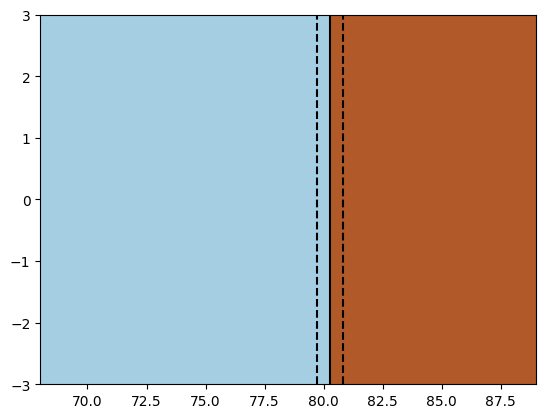

{'TP': 5207,
 'FP': 1425,
 'TN': 4954,
 'FN': 1546,
 'Accuracy': 0.5050258909533963}

In [235]:
scored_resumes = pd.read_csv("data/PM_1_QA_0_DoordashPM-Scored_Resumes.csv")
threshold_outputs = train_model(scored_resumes, "DoorDash PM Score")
plot_threshold(threshold_outputs[0], threshold_outputs[1], threshold_outputs[2])
model_metrics(threshold_outputs[0], threshold_outputs[1], threshold_outputs[2])